In [1]:
# 1) Imports
from pathlib import Path
import json

import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
)

from xgboost import XGBRegressor


In [2]:
# 2) Load dataset + tuned parameters
metrics_path = Path("../models/xgboost/metrics.json")
with metrics_path.open() as fh:
    best_params = json.load(fh)["best_params"]

df = pd.read_csv("../data/curated/rent_features/cleaned_listings.csv")
df["weekly_rent"] = pd.to_numeric(df["weekly_rent"], errors="coerce")
df = df.dropna(subset=["weekly_rent"])

y = df["weekly_rent"].copy()
X = df.drop(columns=["weekly_rent"])


/tmp/ipykernel_13080/1021667247.py:6: DtypeWarning: Columns (16,17,18,20,22,23,25,26,32,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/curated/rent_features/cleaned_listings.csv")


In [3]:
# 3) Column definitions (same as the notebook used originally)
cat_cols = [
    "property_type", "suburb", "postcode",
    "agency_name", "agent_name", "appointment_only",
    "listing_status",
]

num_cols = [
    "bedrooms", "bathrooms", "car_spaces",
    "land_area", "year", "quarter",
    "age_0_to_19", "age_20_to_39", "age_40_to_59", "age_60_plus",
    "avg_days_on_market", "family_percentage", "long_term_resident",
    "median_rent_price", "median_sold_price", "number_sold", "renter_percentage",
    "single_percentage",
]


In [4]:
# 4) Train/val/test split (80/20 with an internal 25% for validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)


In [5]:
# 5) Preprocessing + model pipeline with tuned parameters
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_jobs=-1,
    random_state=42,
    **best_params,
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", xgb),
    ]
)


In [6]:
# 6) Fit on the full training portion (train + val) to match the tuning workflow
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

pipeline.fit(X_train_full, y_train_full)


/home/james/project-2-group-real-estate-industry-project-23-2025/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:44:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "regressor__colsample_bytree", "regressor__gamma", "regressor__learning_rate", "regressor__max_depth", "regressor__min_child_weight", "regressor__n_estimators", "regressor__reg_alpha", "regressor__reg_lambda", "regressor__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
# 7) Evaluate on test set
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
med_ae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE:    {rmse:,.2f}")
print(f"MAE:     {mae:,.2f}")
print(f"MedianAE:{med_ae:,.2f}")
print(f"R^2:     {r2:.4f}")


RMSE:    105.12
MAE:     70.15
MedianAE:47.35
R^2:     0.6601


# Diagnostics


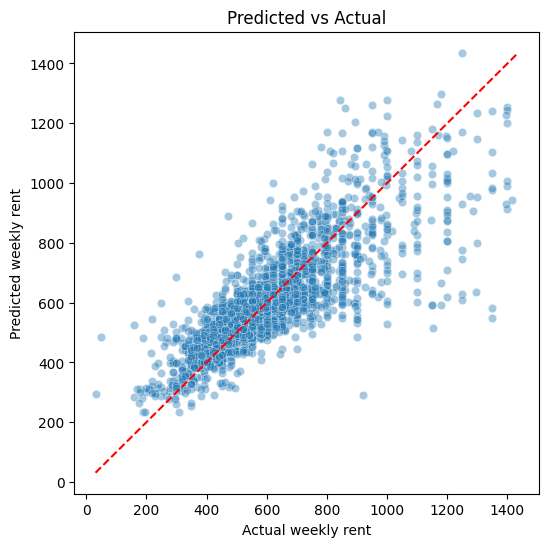

In [8]:
# Predicted vs actual scatter
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, color="red", linestyle="--")
plt.xlabel("Actual weekly rent")
plt.ylabel("Predicted weekly rent")
plt.title("Predicted vs Actual")
plt.show()


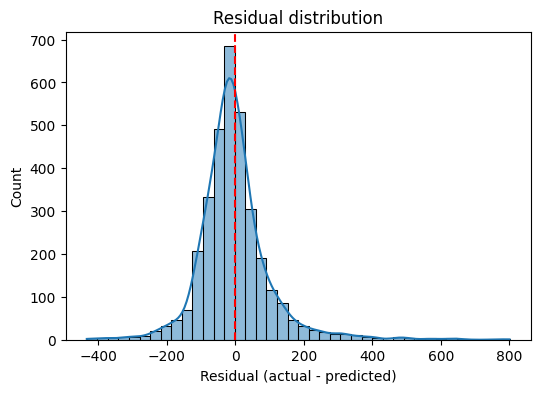

In [9]:
# Residual histogram
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution")
plt.xlabel("Residual (actual - predicted)")
plt.show()


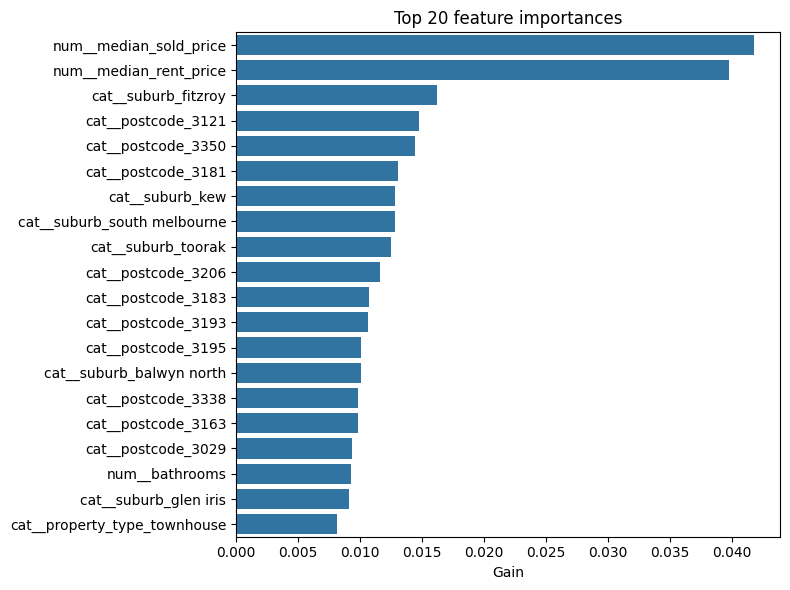

In [10]:
# Feature importance bar plot (top 20)
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = pipeline.named_steps["regressor"].feature_importances_

top_idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8, 6))
sns.barplot(
    x=importances[top_idx],
    y=[feature_names[i] for i in top_idx],
    orient="h",
)
plt.title("Top 20 feature importances")
plt.xlabel("Gain")
plt.ylabel("")
plt.tight_layout()
plt.show()
